In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1 
import scipy.stats as stats
from scipy.stats import loguniform


from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
# альтернативно можно использовать StratifiedKFold т.к. задача классификации

In [2]:
df = pd.read_csv('/content/df2.csv', delimiter = ',')
df=df.drop("class",axis=1)
df.head()

,Make,Model,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,prestige
0,Toyota,Prius,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727,2
1,Renault,Grand Scenic,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000,2
2,Renault,Laguna,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000,3
3,Opel,Astra,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000,3
4,Mercedes,Vito,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636,4


In [3]:
X = df.drop('Transmission', axis=1)
y = df["Transmission"]
y=y.map({"Automatic":1,"Manual":0}).astype(int)
y.value_counts(normalize=True)
     

0    0.54234
1    0.45766
Name: Transmission, dtype: float64

In [5]:
cat_columns = []
num_columns = []

for column_name in X.columns:
    if (X[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))

categorical columns:	  ['Make', 'Model', 'Style', 'Fuel_type'] 
 len =  4
numerical columns:	  ['Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'Age', 'km_year', 'prestige'] 
 len =  6


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
cat_pipe_one = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False))
])

cat_pipe_ordinal = Pipeline([
    ('encoder', OrdinalEncoder( ))
])

numerical_pipe = Pipeline([
    ('scaler', StandardScaler())
])
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_columns),
    ('cat', cat_pipe_one, cat_columns)
])
preprocessors_ = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_columns),
    ('cat', cat_pipe_ordinal, cat_columns)
])
pipe_one = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression())
])
pipe_ordinal = Pipeline([
    ('preprocessors', preprocessors_),
    ('model', LogisticRegression())
])

In [49]:
cv_res = cross_validate(pipe_one, X, y, cv=5, scoring='f1', return_train_score=True)
cv_res

{'fit_time': array([0.91440392, 0.89559007, 0.9528296 , 1.00414419, 0.92974639]),
 'score_time': array([0.02475858, 0.02503943, 0.02532434, 0.02518511, 0.02635908]),
 'test_score': array([0.82631038, 0.84562173, 0.84173172, 0.82720588, 0.81969614]),
 'train_score': array([0.83866125, 0.83338499, 0.83356941, 0.83827362, 0.83987462])}

In [48]:
cv_res = cross_validate(pipe_ordinal, X, y, cv=5, scoring='f1', return_train_score=True)
cv_res

{'fit_time': array([0.22606301, 0.24690247, 0.21700644, 0.22820258, 0.25344658]),
 'score_time': array([0.01773334, 0.01688957, 0.0169301 , 0.01738977, 0.0167625 ]),
 'test_score': array([0.79392118, 0.81295328, 0.80200681, 0.78295156, 0.77154686]),
 'train_score': array([0.79843479, 0.7919739 , 0.79471139, 0.79547973, 0.79785347])}

In [18]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [16]:
param_grid = [{     'model__C':np.logspace(-3,3,7),
                    'model__solver' :['newton-cg', 'lbfgs', 'liblinear'],
                    'model__penalty': ['none', 'l1', 'l2', 'elasticnet']
                  }]

In [19]:
Pipe_GS = GridSearchCV(estimator = pipe_one, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                       cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       verbose = 2 # чтобы он всё подробно расписал. если не интересно - пишем 0
                       )
Pipe_GS.fit(X_train, y_train)
accuracies = {
    'train accuracy': Pipe_GS.score(X_train, y_train),
    'test accuracy': Pipe_GS.score(X_test, y_test)
}

Fitting 5 folds for each of 84 candidates, totalling 420 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=  15.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=  12.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=  17.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=  11.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=  12.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.8s
[CV] END model__C=0.001, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.001, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.001, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.001, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.001, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.001, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.001, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.001, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.001, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.001, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.001,

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.01, model__penalty=none, model__solver=newton-cg; total time=  16.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.01, model__penalty=none, model__solver=newton-cg; total time=  13.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.01, model__penalty=none, model__solver=newton-cg; total time=  17.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.01, model__penalty=none, model__solver=newton-cg; total time=  11.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.01, model__penalty=none, model__solver=newton-cg; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.01, model__penalty=none, model__solver=lbfgs; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.01, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.01, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.01, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=0.01, model__penalty=none, model__solver=lbfgs; total time=   0.9s
[CV] END model__C=0.01, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.01, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.01, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.01, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.01, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.01, model__pena

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.1, model__penalty=none, model__solver=newton-cg; total time=  15.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.1, model__penalty=none, model__solver=newton-cg; total time=  12.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.1, model__penalty=none, model__solver=newton-cg; total time=  17.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.1, model__penalty=none, model__solver=newton-cg; total time=  11.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.1, model__penalty=none, model__solver=newton-cg; total time=  12.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.1, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.1, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.1, model__penalty=none, model__solver=lbfgs; total time=   1.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=0.1, model__penalty=none, model__solver=lbfgs; total time=   1.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=0.1, model__penalty=none, model__solver=lbfgs; total time=   0.9s
[CV] END model__C=0.1, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.1, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.1, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.1, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.1, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.1, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.1, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.1, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.1, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.1, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=0.1, model__penalty=l1, mode

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=none, model__solver=lbfgs; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s
[CV] END model__C=1.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1.0, model__penalty=l1, mode

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s
[CV] END model__C=1.0, model__penalty=l2, model__solver=liblinear; total time=   0.3s
[CV] END model__C=1.0, model__penalty=l2, model__solver=liblinear; total time=   0.2s
[CV] END model__C=1.0, model__penalty=l2, model__solver=liblinear; total time=   0.2s
[CV] END model__C=1.0, model__penalty=l2, model__solver=liblinear; total time=   0.3s
[CV] END model__C=1.0, model__penalty=l2, model__solver=liblinear; total time=   0.2s
[CV] END model__C=1.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=10.0, model__penalty=none, model__solver=newton-cg; total time=  15.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=10.0, model__penalty=none, model__solver=newton-cg; total time=  12.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=10.0, model__penalty=none, model__solver=newton-cg; total time=  16.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=10.0, model__penalty=none, model__solver=newton-cg; total time=  11.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=10.0, model__penalty=none, model__solver=newton-cg; total time=  12.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=10.0, model__penalty=none, model__solver=lbfgs; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=10.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=10.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=10.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=10.0, model__penalty=none, model__solver=lbfgs; total time=   1.1s
[CV] END model__C=10.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=10.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=10.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=10.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=10.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=10.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=10.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=10.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=10.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=10.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=10.0, model__pena

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=10.0, model__penalty=l2, model__solver=lbfgs; total time=   1.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=10.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=10.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=10.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=10.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s
[CV] END model__C=10.0, model__penalty=l2, model__solver=liblinear; total time=   0.3s
[CV] END model__C=10.0, model__penalty=l2, model__solver=liblinear; total time=   0.3s
[CV] END model__C=10.0, model__penalty=l2, model__solver=liblinear; total time=   0.3s
[CV] END model__C=10.0, model__penalty=l2, model__solver=liblinear; total time=   0.3s
[CV] END model__C=10.0, model__penalty=l2, model__solver=liblinear; total time=   0.3s
[CV] END model__C=10.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=10.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=10.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=10.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=10.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] EN

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=100.0, model__penalty=none, model__solver=newton-cg; total time=  14.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=100.0, model__penalty=none, model__solver=newton-cg; total time=  13.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=100.0, model__penalty=none, model__solver=newton-cg; total time=  18.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=100.0, model__penalty=none, model__solver=newton-cg; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=100.0, model__penalty=none, model__solver=newton-cg; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=100.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=100.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=100.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=100.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=100.0, model__penalty=none, model__solver=lbfgs; total time=   1.2s
[CV] END model__C=100.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=100.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=100.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=100.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=100.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=100.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=100.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=100.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=100.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=100.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=100.0,

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=100.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=100.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=100.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=100.0, model__penalty=l2, model__solver=lbfgs; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=100.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s
[CV] END model__C=100.0, model__penalty=l2, model__solver=liblinear; total time=   0.5s
[CV] END model__C=100.0, model__penalty=l2, model__solver=liblinear; total time=   0.4s
[CV] END model__C=100.0, model__penalty=l2, model__solver=liblinear; total time=   0.4s
[CV] END model__C=100.0, model__penalty=l2, model__solver=liblinear; total time=   0.5s
[CV] END model__C=100.0, model__penalty=l2, model__solver=liblinear; total time=   0.4s
[CV] END model__C=100.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=100.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=100.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=100.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=100.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=1000.0, model__penalty=none, model__solver=newton-cg; total time=  15.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=1000.0, model__penalty=none, model__solver=newton-cg; total time=  12.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=1000.0, model__penalty=none, model__solver=newton-cg; total time=  18.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=1000.0, model__penalty=none, model__solver=newton-cg; total time=  12.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=1000.0, model__penalty=none, model__solver=newton-cg; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=1000.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=1000.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=1000.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END model__C=1000.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1000.0, model__penalty=none, model__solver=lbfgs; total time=   0.9s
[CV] END model__C=1000.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=none, model__solver=liblinear; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=l1, model__solver=newton-cg; total time=   0.1s
[CV] END mode

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1000.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1000.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1000.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1000.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model__C=1000.0, model__penalty=l2, model__solver=lbfgs; total time=   0.9s
[CV] END model__C=1000.0, model__penalty=l2, model__solver=liblinear; total time=   0.4s
[CV] END model__C=1000.0, model__penalty=l2, model__solver=liblinear; total time=   0.4s
[CV] END model__C=1000.0, model__penalty=l2, model__solver=liblinear; total time=   0.4s
[CV] END model__C=1000.0, model__penalty=l2, model__solver=liblinear; total time=   0.3s
[CV] END model__C=1000.0, model__penalty=l2, model__solver=liblinear; total time=   0.3s
[CV] END model__C=1000.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=elasticnet, model__solver=newton-cg; total time=   0.1s
[CV] END model__C=1000.0, model__penalty=elasticnet, model__solver=newton-cg; tota

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
210 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  F

In [21]:
     

import warnings
warnings.filterwarnings('ignore')
     

In [22]:
print(accuracies)

{'train accuracy': 0.8566195097236837, 'test accuracy': 0.8561184723304754}


In [23]:

print(Pipe_GS.best_estimator_)
print(Pipe_GS.best_params_)


Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Price(euro)', 'Age',
                                                   'km_year', 'prestige']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                  

Валидационная кривая представляют собой график, показывающий результат на тренировочной и валидационной выборке в зависимости от сложности модели:

если две кривые распологаются близко, и обе ошибки велики, - это признак недообучения

если две кривые далеко друг от друга, - это показатель переобучения

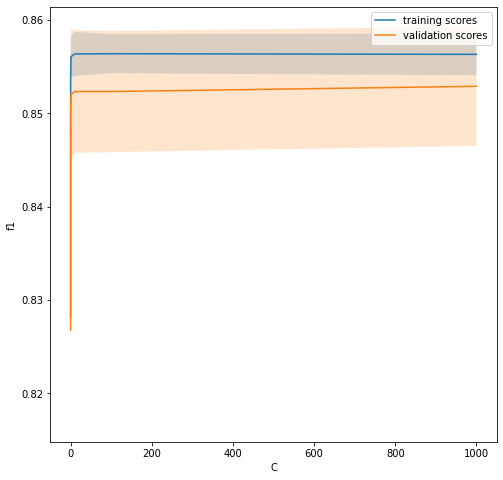

In [62]:
from sklearn.model_selection import validation_curve
param_range=np.logspace(-3,3,7)
alphas = np.logspace(-3, 3, 7)
val_train, val_test = validation_curve(estimator=pipe_one,
                                             X=X, y=y,
                                             cv=5,
param_name='model__C', param_range=param_range)
def plot_with_err(x, data, label):
    mu, std = data.mean(axis=1), data.std(axis=1)
    lines = plt.plot(x, mu,label=label)
    plt.fill_between(x, mu - std, mu + std, facecolor=lines[0].get_color(), alpha=0.2)


plt.figure(figsize=(8,8))
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('f1')
plt.legend()


In [24]:
Pipe_GS = GridSearchCV(estimator = pipe_ordinal, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                       cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       verbose = 2 # чтобы он всё подробно расписал. если не интересно - пишем 0
                       )
Pipe_GS.fit(X_train, y_train)
accuracies = {
    'train accuracy': Pipe_GS.score(X_train, y_train),
    'test accuracy': Pipe_GS.score(X_test, y_test)
}

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.2s
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.2s
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.2s
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.2s
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.2s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.2s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.2s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.3s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.2s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.3s
[CV] END model__C=0.001, model__penalty=none, model__solve

In [25]:
print(accuracies)

{'train accuracy': 0.8178416929732257, 'test accuracy': 0.828526890101325}


In [26]:
print(Pipe_GS.best_estimator_)
print(Pipe_GS.best_params_)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Price(euro)', 'Age',
                                                   'km_year', 'prestige']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type'])])),
                ('model', LogisticRegression(C=10.0))])
{'model__C': 10.0, 'model__penal

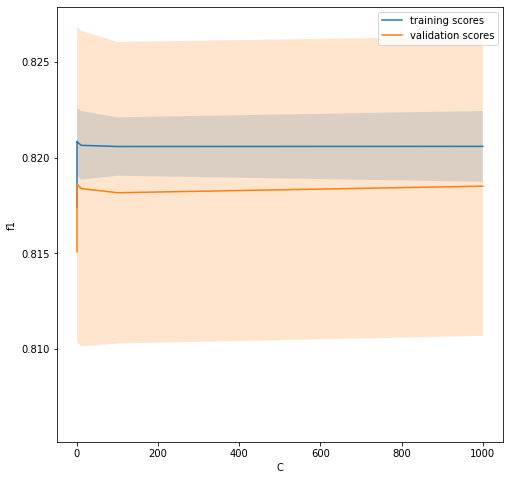

In [59]:

val_train, val_test = validation_curve(estimator=pipe_ordinal,
                                             X=X, y=y,
                                             cv=5,
param_name='model__C', param_range=param_range)


plt.figure(figsize=(8,8))
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('f1')
plt.legend()

In [29]:
cat_pipe_ordinal = Pipeline([
    ('encoder', OrdinalEncoder( ))
])

numerical_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

preprocessors_ = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_columns),
    ('cat', cat_pipe_ordinal, cat_columns)
])

pipe_ordinal_1 = Pipeline([
    ('preprocessors', preprocessors_),
    ('model', LogisticRegression())

])

In [47]:
cv_res = cross_validate(pipe_ordinal_1, X, y, cv=5, scoring='f1', return_train_score=True)
cv_res

{'fit_time': array([0.25611019, 0.26420093, 0.29657435, 0.23848224, 0.27508092]),
 'score_time': array([0.01921654, 0.01843023, 0.01873136, 0.01764655, 0.01857662]),
 'test_score': array([0.79068989, 0.80703535, 0.80352328, 0.78779891, 0.77187619]),
 'train_score': array([0.79754766, 0.79158046, 0.794462  , 0.79678643, 0.79621491])}

In [30]:
Pipe_GS = GridSearchCV(estimator = pipe_ordinal_1, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                       cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       verbose = 2 # чтобы он всё подробно расписал. если не интересно - пишем 0
                       )
Pipe_GS.fit(X_train, y_train)
accuracies = {
    'train accuracy': Pipe_GS.score(X_train, y_train),
    'test accuracy': Pipe_GS.score(X_test, y_test)
}

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.5s
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.6s
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.6s
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.6s
[CV] END model__C=0.001, model__penalty=none, model__solver=newton-cg; total time=   0.6s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.3s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.3s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.3s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.3s
[CV] END model__C=0.001, model__penalty=none, model__solver=lbfgs; total time=   0.3s
[CV] END model__C=0.001, model__penalty=none, model__solve

In [31]:
print(accuracies)

{'train accuracy': 0.8236875949959078, 'test accuracy': 0.8338269680436478}


In [32]:
print(Pipe_GS.best_estimator_)
print(Pipe_GS.best_params_)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Price(euro)', 'Age',
                                                   'km_year', 'prestige']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Make', 'Model', '

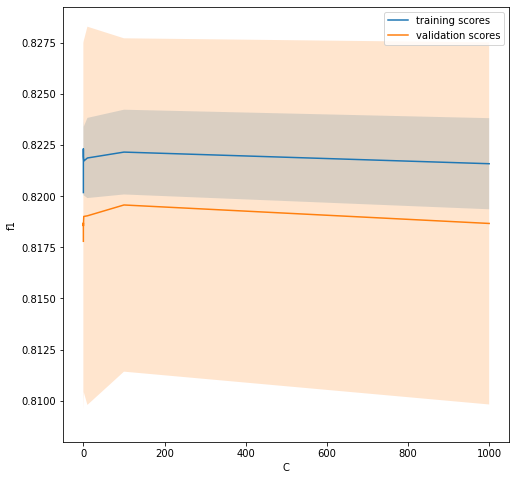

In [60]:
val_train, val_test = validation_curve(estimator=pipe_ordinal_1,
                                             X=X, y=y,
                                             cv=5,
param_name='model__C', param_range=param_range)


plt.figure(figsize=(8,8))
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('f1')
plt.legend()

In [33]:
categorical_pipe = Pipeline([
    ('encoder', OrdinalEncoder( ))
])

numerical_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('PCA', PCA()),
])
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_columns),
    ('cat', categorical_pipe, cat_columns)
])
pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression())
])


In [45]:
from sklearn.model_selection import cross_validate


In [46]:
cv_res = cross_validate(pipe, X, y, cv=5, scoring='f1', return_train_score=True)
cv_res
     

{'fit_time': array([0.32979345, 0.35387564, 0.33585334, 0.31954503, 0.35981822]),
 'score_time': array([0.02005172, 0.02188444, 0.02257562, 0.02241254, 0.02312541]),
 'test_score': array([0.79107981, 0.80779661, 0.80280929, 0.78742233, 0.77079341]),
 'train_score': array([0.79745873, 0.79061356, 0.79400883, 0.79673273, 0.79464165])}

In [34]:
list(range(1,X.shape[1]+1,1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [40]:
param_grid = [{     'model__C':np.logspace(-3,3,7),
                    'model__solver' :['newton-cg', 'lbfgs', 'liblinear'],
                    'model__penalty': ['none', 'l1', 'l2'],
                    'preprocessors__num__PCA__n_components':list(range(1,27,1))
                  }]

In [41]:
Pipe_GS = GridSearchCV(estimator = pipe, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                       cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       verbose = 2 # чтобы он всё подробно расписал. если не интересно - пишем 0
                       )
Pipe_GS.fit(X_train, y_train)
accuracies = {
    'train accuracy': Pipe_GS.score(X_train, y_train),
    'test accuracy': Pipe_GS.score(X_test, y_test)
}

Streaming output truncated to the last 5000 lines.
[CV] END model__C=0.1, model__penalty=l2, model__solver=newton-cg, preprocessors__num__PCA__n_components=15; total time=   0.4s
[CV] END model__C=0.1, model__penalty=l2, model__solver=newton-cg, preprocessors__num__PCA__n_components=15; total time=   0.4s
[CV] END model__C=0.1, model__penalty=l2, model__solver=newton-cg, preprocessors__num__PCA__n_components=15; total time=   0.4s
[CV] END model__C=0.1, model__penalty=l2, model__solver=newton-cg, preprocessors__num__PCA__n_components=15; total time=   0.7s
[CV] END model__C=0.1, model__penalty=l2, model__solver=newton-cg, preprocessors__num__PCA__n_components=15; total time=   0.8s
[CV] END model__C=0.1, model__penalty=l2, model__solver=newton-cg, preprocessors__num__PCA__n_components=16; total time=   0.7s
[CV] END model__C=0.1, model__penalty=l2, model__solver=newton-cg, preprocessors__num__PCA__n_components=16; total time=   0.3s
[CV] END model__C=0.1, model__penalty=l2, model__solv

In [42]:
print(accuracies)

{'train accuracy': 0.8234147862348493, 'test accuracy': 0.8336710833982852}


In [43]:
print(Pipe_GS.best_estimator_)
print(Pipe_GS.best_params_)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=20))]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Price(euro)', 'Age',
                                                   'km_year', 'prestige']),
                                                 ('cat',
                                                  Pipeline(steps=[('enc

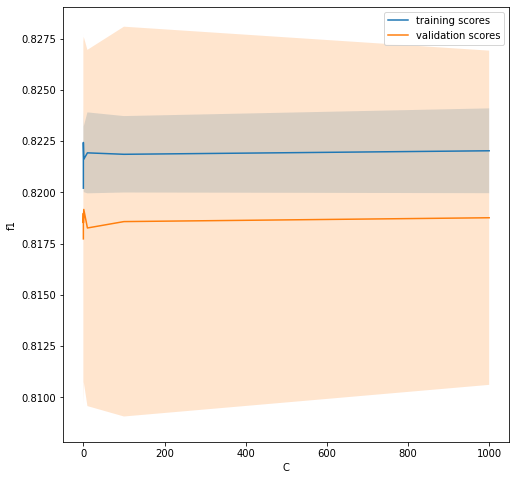

In [61]:
val_train, val_test = validation_curve(estimator=pipe,
                                             X=X, y=y,
                                             cv=5,
param_name='model__C', param_range=param_range)


plt.figure(figsize=(8,8))
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('f1')
plt.legend()

In [44]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_ = DF_Pipe[['param_model__C', 'param_preprocessors__num__PCA__n_components', # берем только гиперпараметры,
             'mean_test_score', #среднее значение метрики на кросс-валидации
             'std_test_score', # разбросс метрики на кросс-валидации
             'rank_test_score']]    # место
cm = sns.light_palette("orange", as_cmap=True) # делаем подсцветку по значению. В этот раз "50 оттенков Оранжевого"
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) # сортируем по убыванию места и раскрашиваем
hl

,param_model__C,param_preprocessors__num__PCA__n_components,mean_test_score,std_test_score,rank_test_score
1397,100.000000,20,0.821512,0.005685,1
1631,1000.000000,20,0.821434,0.005447,2
955,10.000000,20,0.821434,0.005596,3
253,0.010000,20,0.821434,0.005596,3
1163,10.000000,20,0.821434,0.005547,3
1423,1000.000000,20,0.821434,0.005596,3
1319,100.000000,20,0.821434,0.005596,3
721,1.000000,20,0.821434,0.005596,3
19,0.001000,20,0.821434,0.005596,3
1189,100.000000,20,0.821434,0.005596,3
